In [1]:
from __future__ import annotations
try:
    from scripts_for_plotting import *
except ModuleNotFoundError:
    import sys
    sys.path.append('../')
    from scripts_for_plotting import *

import scienceplots
plt.style.use('science')
plt.style.use('notebook')
import ipyparallel as ipp

In [2]:
observed_path = "/media/advait/DATA/research/rcb-project/TSFitPy/input_files/observed_spectra"
star = "WISEJ1942"
observed_file = f"{observed_path}/{star}.txt"
observed_data = np.loadtxt(observed_file, unpack=True)
obs_wave, obs_flux, obs_err = observed_data[0], observed_data[1], observed_data[2]

wavecorr = obs_wave*1e-4
fluxcorr = obs_flux

In [3]:
lists = {}
basepath = "../input_files/linelists/individual/"
lists['CN'] = basepath + "CN_new"
lists['12C16O'] = basepath + "12C16O"
lists['12C18O'] = basepath + "12C18O"
lists['C2'] = basepath + "C2"

lists['atoms'] = basepath + "atoms_4500K"

lines = pd.read_csv("/media/advait/DATA/research/rcb-project/code/lineranges/atomic.csv")
lines['wav'] = lines['wav']*1e-4

In [32]:
turbospectrum_paths = {"turbospec_path": "../turbospectrum/exec-ifx/",  # change to /exec-gf/ if gnu compiler
                       "interpol_path": "../scripts/model_interpolators/",
                       "model_atom_path": "../input_files/nlte_data/model_atoms/",
                       "departure_file_path": "../input_files/nlte_data/",
                    #    "model_atmosphere_grid_path": "../input_files/test_model_atmospheres/",
                        "model_atmosphere_grid_path": "../input_files/hdc_model_atmospheres/",
                       "line_list_path": ""}

teff = 4500
logg = 1.0
met = 0.0
vmic = 7.5
lmin = np.min(obs_wave).round(2)
lmax = 2.5e4
# lmax = 22700
ldelta = 0.1
atmosphere_type = "1D"   # "1D" or "3D"
nlte_flag = False
elements_in_nlte = ["Fe", "Mg"]  # can choose several elements, used ONLY if nlte_flag = True

nguess = 7.0
oguess = 7.5
element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 8.4-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Fe" : -1.0, "Mg" : -1, "S" : -1, "Si": -1, "Na":-1, "Ca":-1, "Co":-1} 
rat = 60
vmac = 4.0
free_isotopes = {"8.016" : rat/(1+rat), "8.017": 0.0, "8.018": 1/(1+rat)}
include_molecules = True  


Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


(0.7, 1.1)

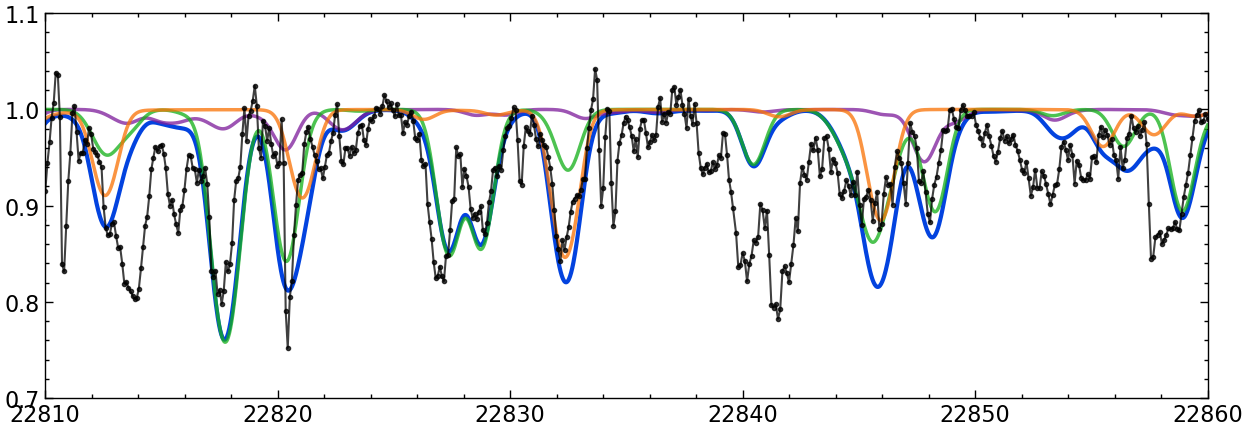

In [33]:
lmin = 22810
lmax = 22860
# element_abundances['S'] = -1
# element_abundances['C'] = 9.75
turbospectrum_paths["line_list_path"] = "../input_files/linelists/linelist_4500K_2/"
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = basepath + "C2"
wavelength, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = basepath + "CN"
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['atoms'] 
wavelength4, syntflux_atoms = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)


plt.figure(figsize=(15, 5))
# plt.axvline(22949.5, color='r', linestyle='--')
# plt.plot(wavelength, flux_c2, 'xkcd:green', lw = 2, alpha = 0.6)
plt.plot(wavelength, flux, 'xkcd:blue', lw = 3,  label="Synthetic")
plt.plot(wavelength, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
plt.plot(wavelength, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = r"CN")
plt.plot(wavelength, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = r"atoms")
# plt.errorbar(obs_wave, obs_flux, yerr=obs_err, fmt="none", ecolor="gray", alpha=0.5)
plt.plot(obs_wave, obs_flux, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.xlim(lmin, lmax)
plt.ylim(0.7, 1.1)

Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


(0.7, 1.1)

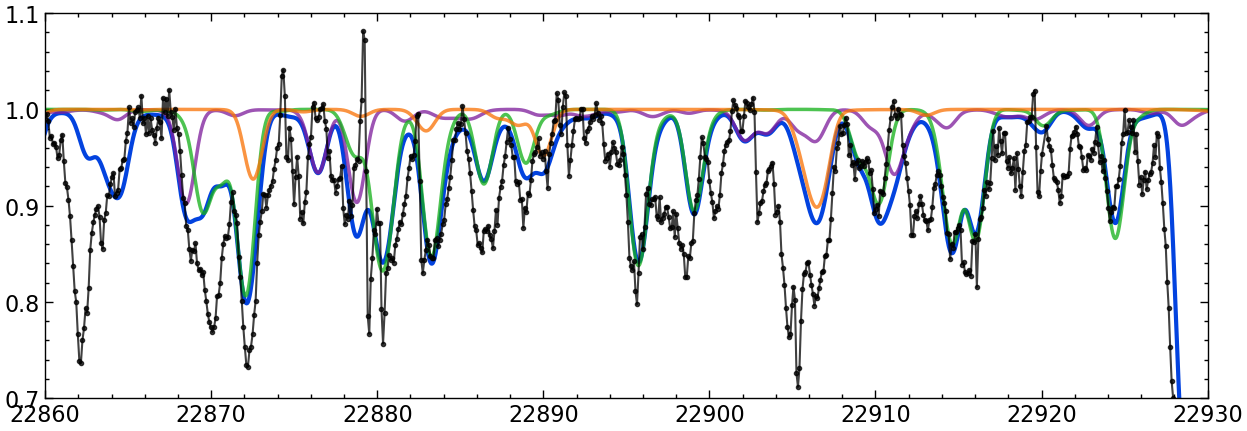

In [34]:
lmin = 22860
lmax = 22930
# element_abundances['S'] = -1
# element_abundances['C'] = 9.75
turbospectrum_paths["line_list_path"] = "../input_files/linelists/linelist_4500K_2/"
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = basepath + "C2"
wavelength, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = basepath + "CN"
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['atoms'] 
wavelength4, syntflux_atoms = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)


plt.figure(figsize=(15, 5))
# plt.axvline(22949.5, color='r', linestyle='--')
# plt.plot(wavelength, flux_c2, 'xkcd:green', lw = 2, alpha = 0.6)
plt.plot(wavelength, flux, 'xkcd:blue', lw = 3,  label="Synthetic")
plt.plot(wavelength, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
plt.plot(wavelength, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = r"CN")
plt.plot(wavelength, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = r"atoms")
# plt.errorbar(obs_wave, obs_flux, yerr=obs_err, fmt="none", ecolor="gray", alpha=0.5)
plt.plot(obs_wave, obs_flux, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.xlim(lmin, lmax)
plt.ylim(0.7, 1.1)

Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


(0.5, 1.1)

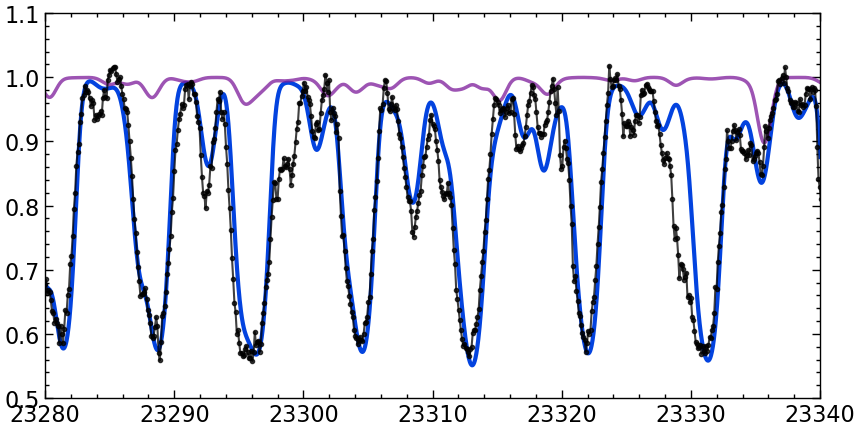

In [35]:
lmin = 23280
lmax = 23340
# element_abundances['S'] = -1
# element_abundances['C'] = 9.75
turbospectrum_paths["line_list_path"] = "../input_files/linelists/linelist_5500K_new/"
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = basepath + "C2"
wavelength, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)



plt.figure(figsize=(10, 5))
# plt.axvline(22949.5, color='r', linestyle='--')
# plt.plot(wavelength, flux_c2, 'xkcd:green', lw = 2, alpha = 0.6)
plt.plot(wavelength, flux, 'xkcd:blue', lw = 3,  label="Synthetic")
plt.plot(wavelength, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
# plt.errorbar(obs_wave, obs_flux, yerr=obs_err, fmt="none", ecolor="gray", alpha=0.5)
plt.plot(obs_wave, obs_flux, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.xlim(lmin, lmax)
plt.ylim(0.5, 1.1)

Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


(0.5, 1.1)

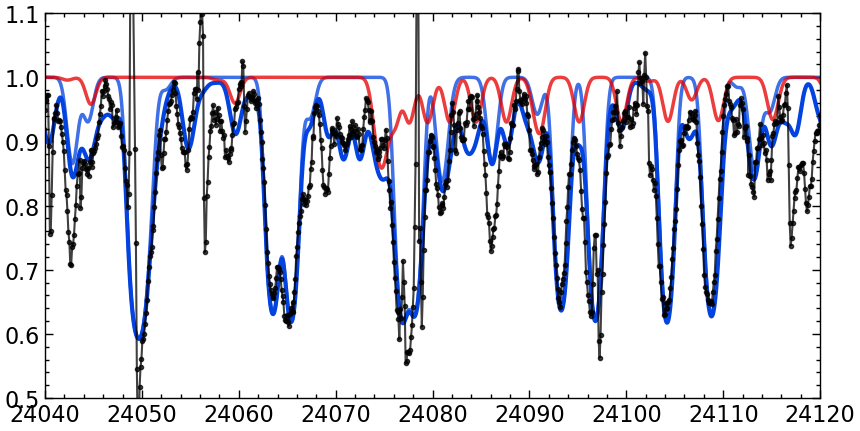

In [36]:
# lmin = 23760
# lmax = 23840
lmin = 24040
lmax = 24120
# element_abundances['S'] = -1
# element_abundances['C'] = 9.75
turbospectrum_paths["line_list_path"] = "../input_files/linelists/linelist_5500K_new/"
wavelength, flux = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules, free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = lists['12C16O'] 
wavelength, syntflux_CO16 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)
turbospectrum_paths["line_list_path"] = lists['12C18O']
wavelength, syntflux_CO18 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)



plt.figure(figsize=(10, 5))
# plt.axvline(22949.5, color='r', linestyle='--')
# plt.plot(wavelength, flux_c2, 'xkcd:green', lw = 2, alpha = 0.6)
plt.plot(wavelength, flux, 'xkcd:blue', lw = 3,  label="Synthetic")
# plt.plot(wavelength, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
plt.plot(wavelength, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}C^{16}O$")
plt.plot(wavelength, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}C^{18}O$")
# plt.errorbar(obs_wave, obs_flux, yerr=obs_err, fmt="none", ecolor="gray", alpha=0.5)
plt.plot(obs_wave, obs_flux, "k.-", alpha=0.75, lw =1.5 ,  label="Observed")
plt.xlim(lmin, lmax)
plt.ylim(0.5, 1.1)

In [47]:
turbospectrum_paths = {"turbospec_path": "../turbospectrum/exec-ifx/",  # change to /exec-gf/ if gnu compiler
                       "interpol_path": "../scripts/model_interpolators/",
                       "model_atom_path": "../input_files/nlte_data/model_atoms/",
                       "departure_file_path": "../input_files/nlte_data/",
                    #    "model_atmosphere_grid_path": "../input_files/test_model_atmospheres/",
                        "model_atmosphere_grid_path": "../input_files/hdc_model_atmospheres/",
                       "line_list_path": ""}

teff = 4500
logg = 1.0
met = 0.0
vmic = 7.5
lmin = np.min(obs_wave).round(2)
lmax = 2.5e4
# lmax = 22700
ldelta = 0.1
atmosphere_type = "1D"   # "1D" or "3D"
nlte_flag = False
elements_in_nlte = ["Fe", "Mg"]  # can choose several elements, used ONLY if nlte_flag = True

nguess = 7.0
oguess = 7.5
element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 8.4-8.56, "N" : nguess-7.98, "O" : oguess-8.77, "Fe" : -1.0, "Mg" : -1, "S" : -1, "Si": -1, "Na":-1, "Ca":-1, "Co":-1, "Ti":-1} 
rat = 60
vmac = 4.0
free_isotopes = {"8.016" : rat/(1+rat), "8.017": 0.0, "8.018": 1/(1+rat)}
include_molecules = True  


In [48]:
turbospectrum_paths['line_list_path'] = lists['CN'] 
wavelength, syntflux_CN = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['12C16O'] 
wavelength1, syntflux_CO16 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['12C18O'] 
wavelength2, syntflux_CO18 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

turbospectrum_paths['line_list_path'] = lists['C2'] 
wavelength3, syntflux_C2 = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

Trimming
LINELIST WARNING! File /media/advait/DATA/research/rcb-project/TSFitPy/lineranges/../input_files/linelists/individual/CN_new/12C14N_TriHy2.plez.bz2 is not a valid linelist file
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed
Trimming
Trimming done
Running TS
TS completed


In [49]:

turbospectrum_paths['line_list_path'] = lists['atoms'] 
wavelength4, syntflux_atoms = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

Trimming
Trimming done
Running TS
TS completed


In [50]:
turbospectrum_paths['line_list_path'] = "../input_files/linelists/linelist_4500K_2/"
wavelength, syntflux_all = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

# turbospectrum_paths['line_list_path'] = lists['C2'] 
# element_abundances ={"H" : 7.5-12, "He" : 11.5-10.93, "C" : 9.5-8.56 + 0.7, "N" : nguess-7.98, "O" : 8.8-8.77, "Na" : 6.9-6.29}  # elemental abundances [X/Fe]; if not written solar scaled ones are used
# wavelength3, syntflux_C2_high = plot_synthetic_data(turbospectrum_paths, teff, logg, met, vmic, lmin, lmax, ldelta, atmosphere_type, nlte_flag, elements_in_nlte, element_abundances, include_molecules,free_isotopes, resolution=75000, macro=vmac, rotation=0, do_matplotlib_plot=False)

Trimming
Trimming done
Running TS
TS completed


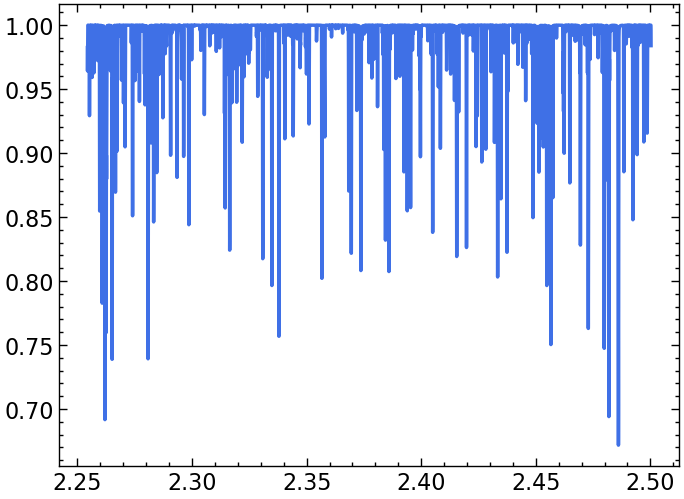

In [51]:
plt.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")

too near
too near
too near
too near
too near
too near
too near


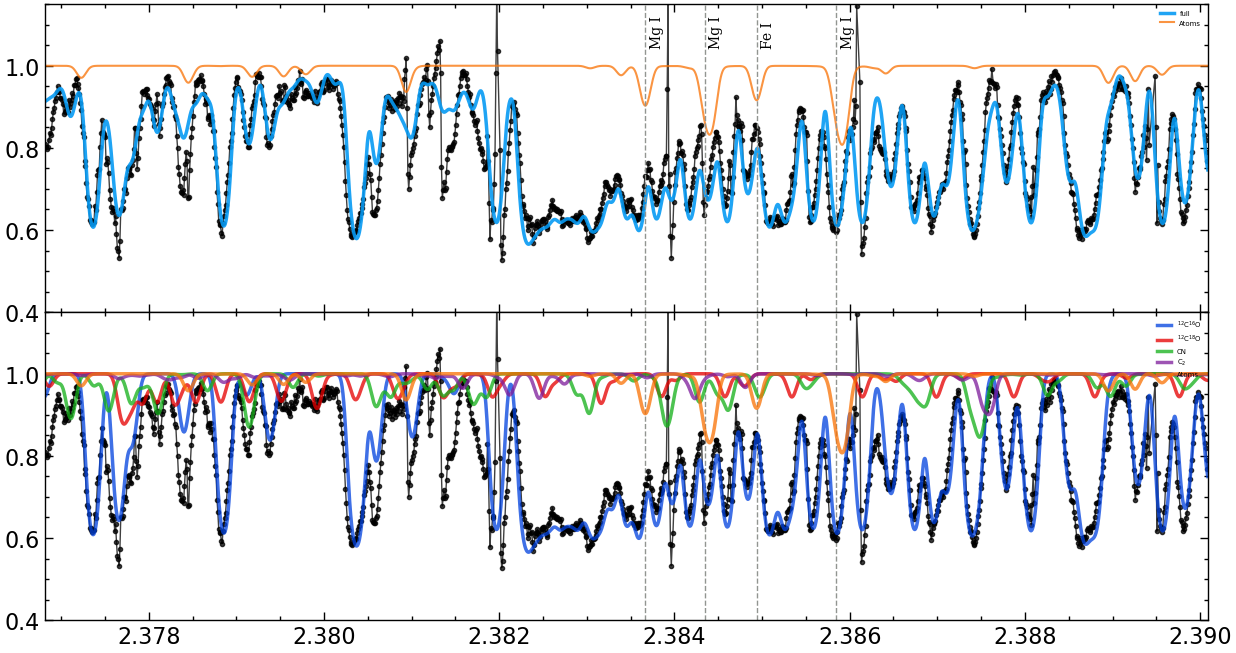

In [52]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

# for i in range(n):
    # i = 2
fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
plt.subplots_adjust(wspace=0, hspace=0)

# wav_range = [2.29, 2.30]
i = 10
buffer = 0.0005
wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)

mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
axs.set_xlim(wav_range)
ax2.set_xlim(wav_range)
axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
axs.set_ylim(0.4, 1.15)
ax2.set_ylim(0.4, 1.15)
axs.legend(fontsize=5, loc = 'upper right')
axs.set_xticklabels([])
prev_wav = 0
prev_name = ''
for idx, row in lines.iterrows():
    near = False
    same = False

    if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
        linewav = row['wav']
        # find nearest syntwave index to linewav
        idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
        thresh = 0.95
        wav_gap_thresh = 1e-4
        if syntflux_atoms[idx] < thresh:
            near = abs(prev_wav - linewav) < wav_gap_thresh
            # print(abs(prev_wav - linewav))
            # print(near)
            same = prev_name == row['name']
            if (not near) :
                axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                prev_wav, prev_name = row['wav'], row['name']
            else:
                print("too near")
ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
# offset = -5e-4
ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
# 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
ax2.legend(fontsize=5, loc = 'upper right')


In [43]:
# create a directory for the star name in this folder if it doesnt exist
if not os.path.exists(f"./{star}"):
    os.makedirs(f"./{star}")

In [53]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

for i in range(n):
    # i = 2
    fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    plt.subplots_adjust(wspace=0, hspace=0)
    buffer = 0.0005
    wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)
    mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
    axs.set_xlim(wav_range)
    ax2.set_xlim(wav_range)
    axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    # axs.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    # axs.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    # axs.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
    # axs.plot(wavelength*1e-4, syntflux_C2_high, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$+ 0.7")
    # axs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    axs.set_ylim(0.4, 1.15)
    ax2.set_ylim(0.4, 1.15)
    axs.legend(fontsize=5, loc = 'upper right')
    axs.set_xticklabels([])
    # axs.grid(which='both', linestyle='--', alpha = 0.5)

    

    # find the lines in the range
    prev_wav = 0
    prev_name = ''
    for idx, row in lines.iterrows():
        near = False
        same = False

        if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
            linewav = row['wav']
            # find nearest syntwave index to linewav
            idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
            thresh = 0.95
            wav_gap_thresh = 1e-4
            if syntflux_atoms[idx] < thresh:
                near = abs(prev_wav - linewav) < wav_gap_thresh
                same = prev_name == row['name']
                if (not near) :
                    axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    prev_wav, prev_name = row['wav'], row['name']
                else:
                    print("too near")
    ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
    # 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    ax2.legend(fontsize=5, loc = 'upper right')

    

    # save the plot
    plt.savefig(f'./{star}/{i}.png', dpi=300)
    # break
    plt.close()
    # axs.close()
    # axs[i].axhline(1.0, color = 'black', lw = 0.5)


too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near


In [45]:
lmask_path = "/media/advait/DATA/research/rcb-project/TSFitPy/input_files/linemask_files/N/low-n-lmask.txt"
lmask = np.loadtxt(lmask_path, unpack=True, comments=";")
mid, left, right = lmask[0], lmask[1], lmask[2]

In [65]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

for i in range(n):

    # i = 4
    fig, (axs, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    plt.subplots_adjust(wspace=0, hspace=0)
    buffer = 0.0005
    wav_range = (wavmin + i/n*wavspan - buffer, wavmin + (i+1)/n*wavspan + buffer)
    mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])

    axs.set_xlim(wav_range)
    ax2.set_xlim(wav_range)
    for line in mid:
        axs.axvline(line*1e-4, color = 'xkcd:blue', lw = 1)
        if line*1e-4 > wav_range[0] and line*1e-4 < wav_range[1]:
            axs.text(line*1e-4+0.00005, 1.02, str(line), rotation = 90, fontsize = 10, fontname = 'serif')
        # axs.text(line*1e-4, 1.05, str(line), rotation = 90, fontsize = 10, fontname = 'serif')
        ax2.axvline(line*1e-4, color = 'xkcd:blue', lw = 1)
    for line in left:
        axs.axvline(line*1e-4, color = 'xkcd:red', lw = 1)
        ax2.axvline(line*1e-4, color = 'xkcd:red', lw = 1)
    for line in right:
        axs.axvline(line*1e-4, color = 'xkcd:red', lw = 1)
        ax2.axvline(line*1e-4, color = 'xkcd:red', lw = 1)
    axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    # axs.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    # axs.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    # axs.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
    # axs.plot(wavelength*1e-4, syntflux_C2_high, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$+ 0.7")
    # axs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    axs.set_ylim(0.4, 1.15)
    ax2.set_ylim(0.4, 1.15)
    axs.legend(fontsize=5, loc = 'upper right')
    axs.set_xticklabels([])
    # axs.grid(which='both', linestyle='--', alpha = 0.5)



    

    # find the lines in the range
    prev_wav = 0
    prev_name = ''
    for idx, row in lines.iterrows():
        near = False
        same = False

        if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
            linewav = row['wav']
            # find nearest syntwave index to linewav
            idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
            thresh = 0.95
            wav_gap_thresh = 1e-4
            if syntflux_atoms[idx] < thresh:
                near = abs(prev_wav - linewav) < wav_gap_thresh
                same = prev_name == row['name']
                if (not near) :
                    axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                    # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                    prev_wav, prev_name = row['wav'], row['name']
                else:
                    print("too near")
    ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
    ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
    ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
    ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
    ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
    # 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
    ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
    ax2.legend(fontsize=5, loc = 'upper right')

    

    # save the plot
    plt.savefig(f'./{star}/masks/CN_{i}.png', dpi=300)
    # break
    plt.close()
    # axs.close()
    # axs[i].axhline(1.0, color = 'black', lw = 0.5)


too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near
too near


23336.85  23334.00  23339.70


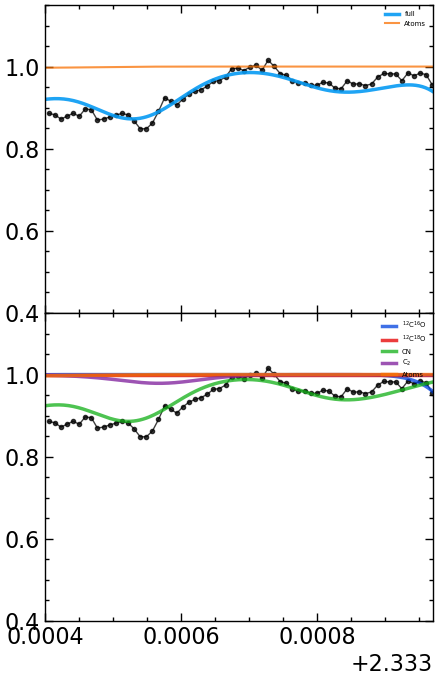

In [163]:
n = 20

mask = wavecorr < 2.5
fluxcorr = fluxcorr[mask]
wavecorr = wavecorr[mask]
wavmin = np.min(wavecorr)
wavspan = np.max(wavecorr)-np.min(wavecorr)

# for i in range(n):
    # i = 2
fig, (axs, ax2) = plt.subplots(2, 1, figsize=(5, 8))
plt.subplots_adjust(wspace=0, hspace=0)

# wav_range = [2.4688, 2.4702]
# l,r = wav_range

l, r = 23334.0,  23339.70 
l, r = l*1e-4, r*1e-4
wav_range = [l, r]

mask = (wavecorr > wav_range[0]) & (wavecorr < wav_range[1])
axs.set_xlim(wav_range)
ax2.set_xlim(wav_range)
axs.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
axs.plot(wavelength*1e-4, syntflux_all, lw = 2.5, c = 'xkcd:azure', alpha = 0.9, label = r"full")
axs.plot(wavelength*1e-4, syntflux_atoms, lw = 1.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
axs.set_ylim(0.4, 1.15)
ax2.set_ylim(0.4, 1.15)
axs.legend(fontsize=5, loc = 'upper right')
axs.set_xticklabels([])
prev_wav = 0
prev_name = ''
for idx, row in lines.iterrows():
    near = False
    same = False

    if row['wav'] > wav_range[0] and row['wav'] < wav_range[1]:
        linewav = row['wav']
        # find nearest syntwave index to linewav
        idx = np.argmin(np.abs(wavelength*1e-4 - linewav))
        thresh = 0.95
        wav_gap_thresh = 1e-4
        if syntflux_atoms[idx] < thresh:
            near = abs(prev_wav - linewav) < wav_gap_thresh
            same = prev_name == row['name']
            if (not near) :
                axs.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                axs.text(row['wav']+5e-5, 1.05, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                ax2.axvline(row['wav'], color = 'xkcd:gray', linestyle='--', lw=1)
                # ax2.text(row['wav']+5e-5, 1.15, row['name'], rotation = 90, fontsize = 10, fontname = 'serif')
                prev_wav, prev_name = row['wav'], row['name']
            else:
                print("too near")
ax2.plot(wavecorr[mask], fluxcorr[mask], "k.-", lw = 1, alpha=0.75)
ax2.plot(wavelength*1e-4, syntflux_CO16, lw = 2.5, c = 'xkcd:blue', alpha = 0.76, label = r"$^{12}$C$^{16}$O")
ax2.plot(wavelength*1e-4, syntflux_CO18, lw = 2.5, c = 'xkcd:red', alpha = 0.76, label = r"$^{12}$C$^{18}$O")
ax2.plot(wavelength*1e-4, syntflux_CN, lw = 2.5, c = 'xkcd:green', alpha = 0.76, label = "CN")
ax2.plot(wavelength*1e-4, syntflux_C2, lw = 2.5, c = 'xkcd:purple', alpha = 0.76, label = r"C$_2$")
# 2xs.plot(syntwave_CH*1e-4, syntflux_CH, lw = 2.5, c = 'xkcd:pink', alpha = 0.76, label = "CH")
ax2.plot(wavelength*1e-4, syntflux_atoms, lw = 2.5, c = 'xkcd:orange', alpha = 0.76, label = "Atoms")
ax2.legend(fontsize=5, loc = 'upper right')
print(f"{(0.5*(l+r)*1e4):.2f}  {l*1e4:.2f}  {r*1e4:.2f}")